In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import colors
import os 

def open_og_grid(og_path):
    with open(og_path, 'rb') as f:
        og = np.load(f)
    return og

out_path = '../dataset/Map_3'
og_path = '../dataset/Map_3/occupancy_grid.npy'
occupancy_grid = open_og_grid(og_path)

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import colors
import os 
from IPython.display import HTML
from matplotlib import animation

class AStarPlanner:

    def __init__(self, resolution, rr, obstacle_map= None, 
                 show_animation=True, step=50, export_imgs=True, out_path='../dataset'):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()

        self.obstacle_map = obstacle_map
        self.get_og_map_info(obstacle_map)
        
        self.iterations = 0
        self.path_length = 0
        
        self.show_animation = show_animation
        if self.show_animation:
            self.fig = None
            self.ax = None
            self.pts = None
            self.x_plts = []
            self.y_plts = []
            self.txt_title = None
            self.anim = None
            self.sx = 0
            self.sy = 0
            self.gx = 0
            self.gy = 0
            self.rx = None
            self.ry = None
            self.path = None
            self.step = step
            self.out_path = out_path
            self.export_imgs = export_imgs
    
    def create_figure(self):
        
        danger_color = (0.3, 0.3, 0.3, 0.6)
        safe_color = (0.9, 1, 0.9, 0.1)

        markers_color = (0.92, 0.7, 0, 1)

        font = {'family': "monospace",
            'color':  (0.92, 0.7, 0, 1),
            'weight': 'bold',
            'size': 10,
            }


        cmp=ListedColormap([danger_color, safe_color])
        with plt.style.context('ggplot'):
                        
            self.fig = plt.figure(figsize=(10,10), dpi=120)
            self.ax = plt.subplot(1,1,1)   
            xi = np.arange(self.min_x, self.max_x, 1) * self.resolution # Grid in meters
            yi = np.arange(self.min_y, self.max_y, 1) * self.resolution # Grid in meters
            #Z = 
            #plt.pcolormesh(safe_slope, cmap='Greys')
            #plt.scatter(xi,yi, cmap='Greys')

            self.ax.imshow(self.obstacle_map, cmap=cmp)

            plt.title("Punkt startu i mety dla trasy", fontsize=14)
            plt.xlabel("Kierunek x [m]", fontsize=10)
            plt.ylabel("Kierunek Y [m]", fontsize=10)
            self.ax.invert_yaxis()

            locs_x = (np.arange(self.min_x, self.max_x, step=self.step)) 
            labels_x = locs_x/2
            plt.xticks(ticks=locs_x, labels=labels_x)

            locs_y = (np.arange(self.min_y, self.max_y, step=self.step)) 
            labels_y = locs_y/2
            plt.yticks(ticks=locs_y, labels=labels_y)
            
            self.pts, = self.ax.plot([], [], 'g.', ms=6)
            self.path, = self.ax.plot([], [], 'r-', ms=8)

            start_point = self.ax.plot(self.sy, self.sx, marker="H", markeredgecolor=markers_color,
                                markersize=12, markerfacecolor=markers_color, label='Punkt startowy') # Start point plot 

            end_point = self.ax.plot(self.gy, self.gx, marker="X", label='Punkt końcowy', 
                                markersize=12, markeredgecolor='b',markerfacecolor='b') # End point plot )
            self.ax.grid(True)
            self.ax.axis("equal")
            
#             self.fig = plt.figure(figsize=(10,10), dpi=120)
#             self.ax = plt.subplot(1,1,1)   
#             self.ax.imshow(self.obstacle_map, cmap='Greys')
#             # set up the subplots as needed
#             self.pts, = self.ax.plot([], [], 'g.', ms=6)
#             self.path, = self.ax.plot([], [], 'r-', ms=8)
#             self.ax.plot(self.sy, self.sx, "or", ms=12)
#             self.ax.plot(self.gy, self.gx, "xb", ms=12)
#             self.ax.grid(True)
#             self.ax.set_xlim((self.min_x, self.max_x))            
#             self.ax.set_ylim((self.min_y, self.max_y))
#             self.ax.set_xlabel('Kierunek X')
#             self.ax.set_ylabel('Kierunek Y')
       # ax.set_title('Planowanie trasy')
        
            self.txt_title = self.ax.set_title('')

    def ani_init(self):
        self.pts.set_data([], [])
        self.path.set_data([], [])
        return self.pts,self.path
    
    def animate(self, n):
        if n<=len(self.x_plts):
            self.pts.set_data(self.y_plts[:n],self.x_plts[:n])
        else:
            if self.rx is not None:
                self.path.set_data(self.ry[:n-len(self.x_plts)],self.rx[:n-len(self.x_plts)])
        self.txt_title.set_text('Algorytm krok numer = {0:4d}'.format(n))
        return self.pts,self.path
    
    def create_animation(self):
        self.create_figure()
        self.anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.ani_init,
                                            frames=len(self.x_plts)+len(self.rx), interval=10, blit=True)
        return self.anim
    
    def plot_searched_points(self):
        
        danger_color = (0.3, 0.3, 0.3, 0.6)
        safe_color = (0.9, 1, 0.9, 0.1)

        markers_color = (0.92, 0.7, 0, 1)

        font = {'family': "monospace",
            'color':  (0.92, 0.7, 0, 1),
            'weight': 'bold',
            'size': 10,
            }


        cmp=ListedColormap([danger_color, safe_color])
        with plt.style.context('ggplot'):
            fig, ax = plt.subplots(figsize=(10,10), dpi=144)
            xi = np.arange(self.min_x, self.max_x, 1) * self.resolution # Grid in meters
            yi = np.arange(self.min_y, self.max_y, 1) * self.resolution # Grid in meters
            #Z = 
            #plt.pcolormesh(safe_slope, cmap='Greys')
            #plt.scatter(xi,yi, cmap='Greys')

            ax.imshow(self.obstacle_map, cmap=cmp)

            plt.title("Wynik działania algorytmu A*", fontsize=14)
            plt.xlabel("Kierunek x [m]", fontsize=10)
            plt.ylabel("Kierunek Y [m]", fontsize=10)
            ax.invert_yaxis()

            locs_x = (np.arange(self.min_x, self.max_x, step=self.step)) 
            labels_x = locs_x/2
            plt.xticks(ticks=locs_x, labels=labels_x)

            locs_y = (np.arange(self.min_y, self.max_y, step=self.step)) 
            labels_y = locs_y/2
            plt.yticks(ticks=locs_y, labels=labels_y)

            search_point = ax.plot(self.y_plts, self.x_plts,'g.', ms=6)
            start_point = ax.plot(self.sy, self.sx, marker="H", markeredgecolor=markers_color,
                                markersize=12, markerfacecolor=markers_color, label='Punkt startowy') # Start point plot 

            end_point = ax.plot(self.gy, self.gx, marker="X", label='Punkt końcowy', 
                                markersize=12, markeredgecolor='b',markerfacecolor='b') # End point plot )
            
            path_plot = ax.plot(self.ry, self.rx, "r-", ms=8)
            
            ax.grid(True)
            ax.axis("equal")
            
            if self.export_imgs:
                out_path = os.path.join(self.out_path, 'searched_points.jpeg')
                plt.savefig(out_path)
        plt.show()
        
    def plot_start_end_points(self):

        danger_color = (0.3, 0.3, 0.3, 0.6)
        safe_color = (0.9, 1, 0.9, 0.1)

        markers_color = (0.92, 0.7, 0, 1)

        font = {'family': "monospace",
            'color':  (0.92, 0.7, 0, 1),
            'weight': 'bold',
            'size': 10,
            }


        cmp=ListedColormap([danger_color, safe_color])
        with plt.style.context('ggplot'):
            fig, ax = plt.subplots(figsize=(10,10), dpi=144)
            xi = np.arange(self.min_x, self.max_x, 1) * self.resolution # Grid in meters
            yi = np.arange(self.min_y, self.max_y, 1) * self.resolution # Grid in meters
            #Z = 
            #plt.pcolormesh(safe_slope, cmap='Greys')
            #plt.scatter(xi,yi, cmap='Greys')

            ax.imshow(self.obstacle_map, cmap=cmp)

            plt.title("Punkt startu i mety dla trasy", fontsize=14)
            plt.xlabel("Kierunek x [m]", fontsize=10)
            plt.ylabel("Kierunek Y [m]", fontsize=10)
            ax.invert_yaxis()

            locs_x = (np.arange(self.min_x, self.max_x, step=self.step)) 
            labels_x = locs_x/2
            plt.xticks(ticks=locs_x, labels=labels_x)

            locs_y = (np.arange(self.min_y, self.max_y, step=self.step)) 
            labels_y = locs_y/2
            plt.yticks(ticks=locs_y, labels=labels_y)


            start_point = ax.plot(self.sy, self.sx, marker="H", markeredgecolor=markers_color,
                                markersize=12, markerfacecolor=markers_color, label='Punkt startowy') # Start point plot 

            end_point = ax.plot(self.gy, self.gx, marker="X", label='Punkt końcowy', 
                                markersize=12, markeredgecolor='b',markerfacecolor='b') # End point plot )
            ax.grid(True)
            ax.axis("equal")
            
            if self.export_imgs:
                out_path = os.path.join(self.out_path, 'start_end_points.jpeg')
                plt.savefig(out_path)
        plt.show()
      
    def get_og_map_info(self, og_map):
            self.max_x = round(og_map.shape[0])
            self.max_y = round(og_map.shape[1])
            self.x_width = round(self.max_x - self.min_x)
            self.y_width = round(self.max_y - self.min_y)
    
    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion

    
    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round(position - min_pos) 
    
    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]: 
            return False
        return True

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry
    
    def set_goals(self, sx, sy, gx, gy):
        self.sx = sx
        self.sy = sy
        self.gx = gx
        self.gy = gy
        
    def planning(self, sx=None, sy=None, gx=None, gy=None):
        """
        A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """
        if sx is None:
            sx = self.sx
            sy = self.sy
            gx = self.gx
            gy = self.gy
        else:
            self.set_goals(self, sx, sy, gx, gy)
        
        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while 1:
            self.iterations += 1
            
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node,
                                                                     open_set[
                                                                         o]))
            current = open_set[c_id]
            
            # show graph
            if self.show_animation:  # pragma: no cover
#                 sub_plt = plt.plot(self.calc_grid_position(current.x, self.min_x),
#                          self.calc_grid_position(current.y, self.min_y), "xc")
#                 self.plts.append(sub_plt)
                self.x_plts.append(self.calc_grid_position(current.x, self.min_x))
                self.y_plts.append(self.calc_grid_position(current.y, self.min_y))


            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current
            
            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node
                  #      print('ID: {} \n Best path set: {}'.format(n_id,open_set[n_id]))

            
        self.rx, self.ry = self.calc_final_path(goal_node, closed_set)
        
        if self.show_animation:
            self.anim = self.create_animation()

        return self.rx, self.ry
    
    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent_index)

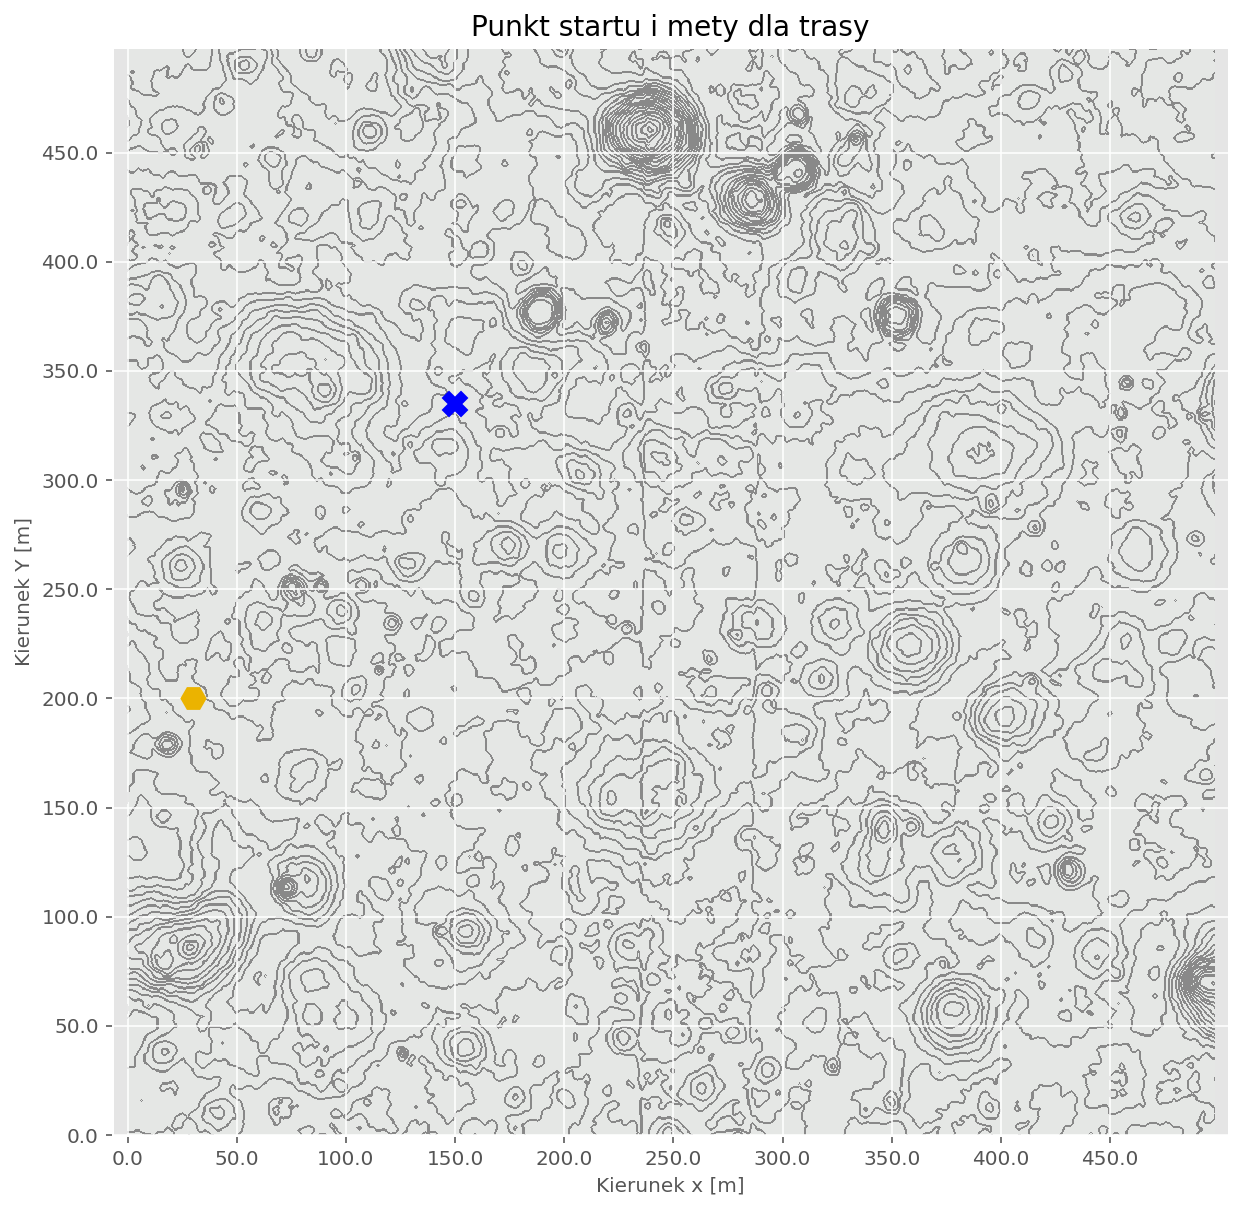

In [3]:
sx = 400.0  # [m]
sy = 60.0  # [m]
gx = 335.0*2  # [m]
gy = 150.0*2 # [m]
grid_size = 0.5 # 0.5  # [m]
robot_radius = 1.0  # [m]

a_star = AStarPlanner(resolution=grid_size, rr=robot_radius, obstacle_map=occupancy_grid, show_animation=True,
                     out_path=out_path, step=100)
a_star.set_goals(sx, sy, gx, gy)
a_star.plot_start_end_points()


Find goal


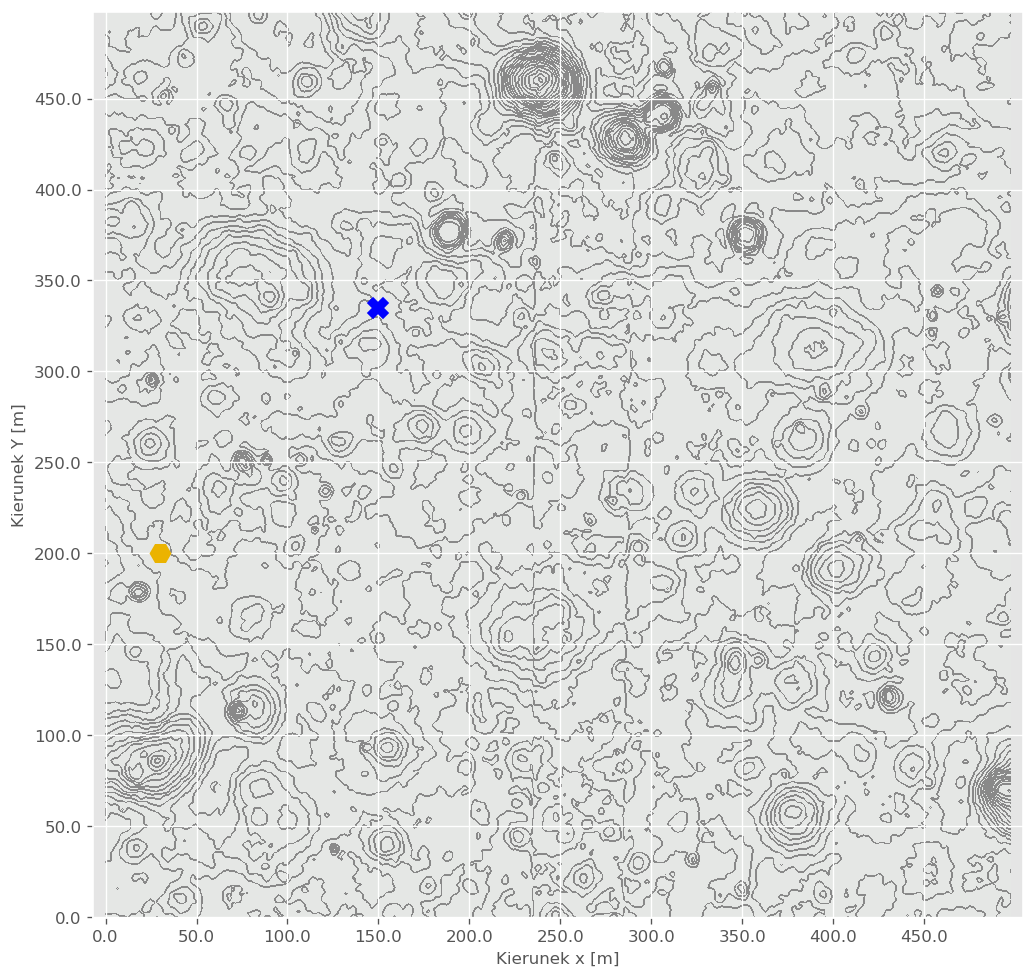

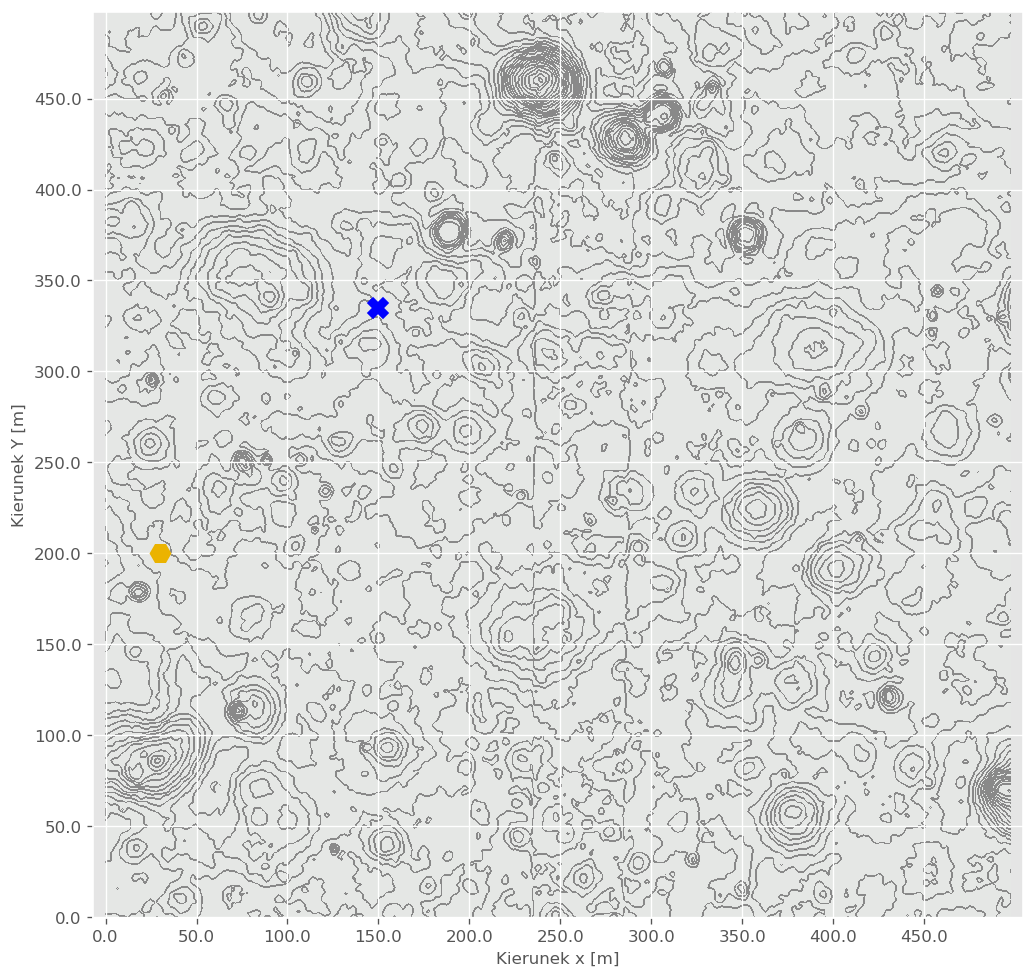

In [4]:
from IPython.display import HTML
from matplotlib import animation


#a_star = AStarPlanner(resolution=1, rr=1, obstacle_map=occupancy_grid, show_animation=True)
rx, ry = a_star.planning()

# blit=True re-draws only the parts that have changed.
anim = a_star.create_animation()
#extra_args = ['vcodec',     'libx264']
#anim.save("../dataset/Small_map.mp4", fps = 30)


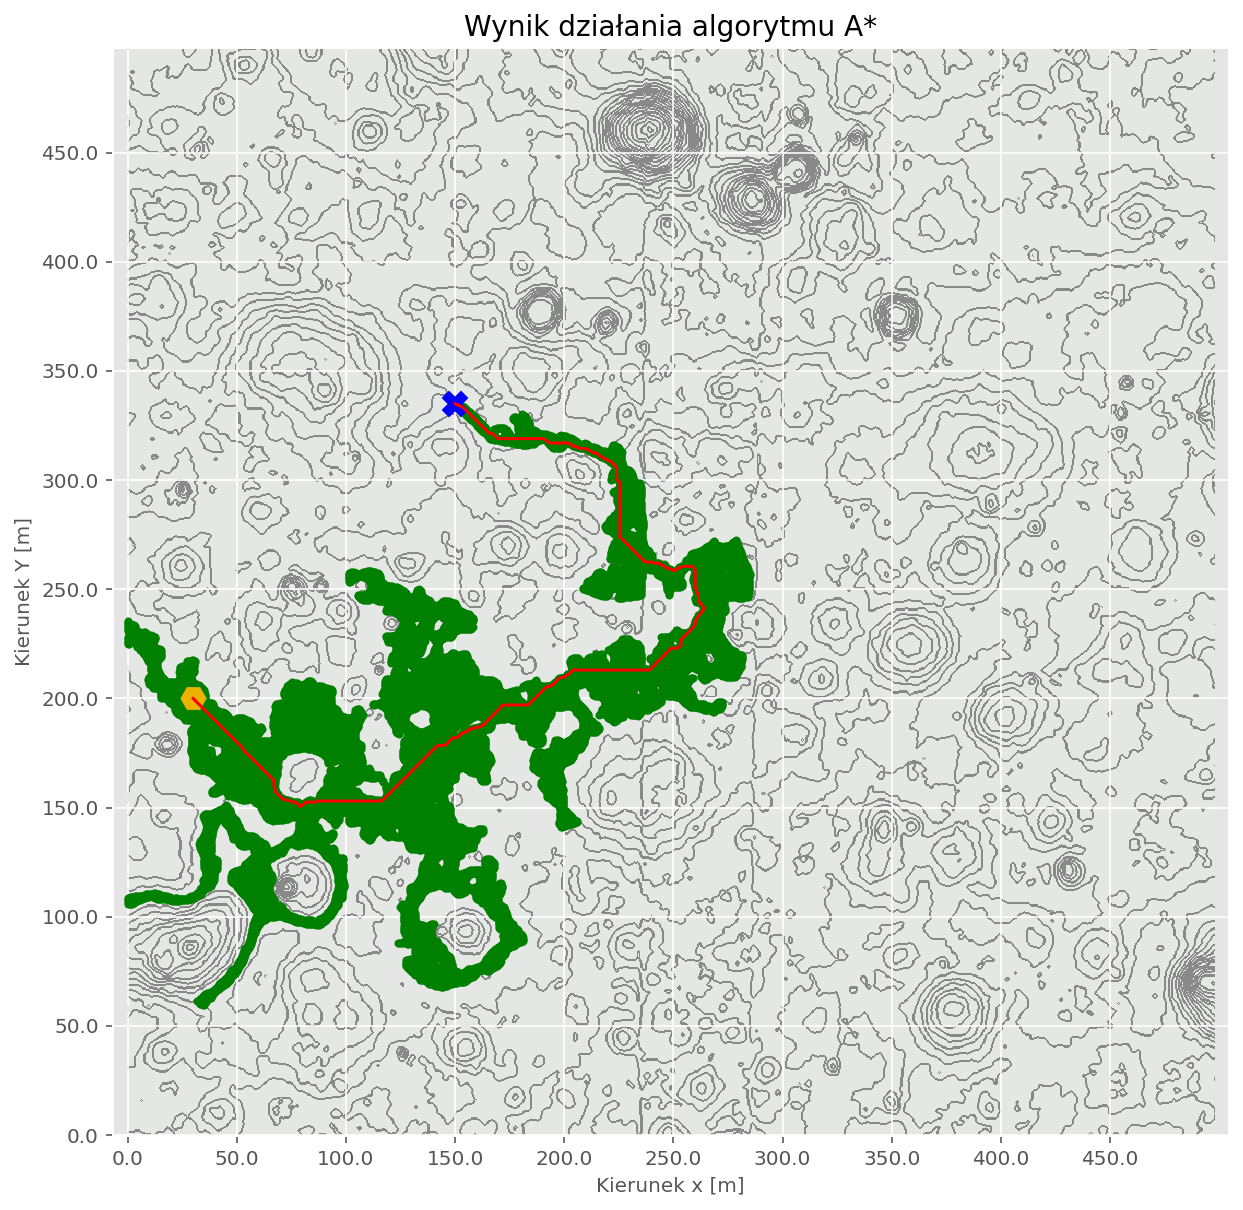

In [5]:
a_star.plot_searched_points()

In [6]:
# HTML(anim.to_html5_video())

In [7]:
# anim.save("../dataset/Small_map/path_a_star.mp4", fps = 30)